# Assignment 2.2 - Gaussian Mixture Model - GMM

Please submit your solution of this notebook in the Whiteboard at the corresponding Assignment entry as .ipynb-file and as .pdf. <br><br>
Please do **NOT** rename the file!

#### State both names of your group members here:
[Jane and John Doe]

In [ ]:
# Daniel Thompson and Paola Gega

## Grading Info/Details - Assignment 2.2:

The assignment will be graded semi-automatically, which means that your code will be tested against a set of predefined test cases and qualitatively assessed by a human. This will speed up the grading process for us.

* For passing the test scripts: 
    - Please make sure to **NOT** alter predefined class or function names, as this would lead to failing of the test scripts.
    - Please do **NOT** rename the files before uploading to the Whiteboard!

* **(RESULT)** tags indicate checkpoints that will be specifically assessed by a human.

* You will pass the assignment if you pass the majority of test cases and we can at least confirm effort regarding the **(RESULT)**-tagged checkpoints per task.

## Task 2.2.1 - GMMs

GMMs are a probabilistic model for representing normally distributed subpopulations within an overall population. They assume that the data is generated from a mixture of several Gaussian distributions with unknown parameters. The goal is to estimate the parameters of these Gaussian distributions (mean, covariance) and the mixing coefficients.

* Implement the GMM logic using the class structure below. The GMM class should be able to fit to data using the EM algorithm. **(RESULT)**
* Visualize the performance of your GMM implementation on synthetic data, i.e., generate data from known Gaussian distributions and show how well your GMM can recover the original parameters. **(RESULT)**

In [ ]:
import numpy as np
# from scipy.stats import multivariate_normal
# We will just use numpy
import matplotlib.pyplot as plt

In [ ]:
class GMM:
    """
    Gaussian Mixture Model implementation using Expectation-Maximization algorithm.
    """
    def __init__(self, k=3, max_iters=100, tol=1e-4, random_state=None, silent=False):
        """
        Initialize EM clusterer for a GMM.
        
        Parameters:
        -----------
        k : int
            Number of clusters
        max_iters : int
            Maximum number of iterations
        tol : float
            Tolerance for convergence (change in centroids)
        random_state : int or None
            Random seed for reproducibility
        """
        self.labels = None
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        self.silent = silent

    def initialize_parameters(self, X):
        """
        For the initial means we choose k distinct random points from the data
        Then we randomly generate mixture weights and covariance matrices
        For simplicity we initialize all covariance matrices as Id
        """
        rng = np.random.default_rng(seed=self.random_state)
        n = len(X)
        self.labels = np.empty(n, dtype=int)
        inds = rng.choice(n, self.k, replace=False)
        # k x n matrix whole rows are the centroids of the clusters
        self.mu = X[inds]
        # k-dim vector of latent probabilities
        self.pi = rng.random(self.k)
        self.pi = self.pi / np.sum(self.pi)
        # (k, n, n) shaped array
        # Use broadcasting to create a list of k identity matrices
        self.Sigma = np.zeros((self.k,n,n)) + np.eye(n)
    
    def _e_step(self, X):
        """Expectation step"""
        pass
        # TODO: Implement this function
    
    def _m_step(self, X, responsibilities):
        """Maximization step"""
        pass
        # TODO: Implement this function
    
    def fit(self, X):
        """Fit GMM to data using EM algorithm."""
        self.initialize_parameters(X)
    
    def predict(self, X):
        """
        Predict the component label for each sample.
        """
        # TODO
        return self.labels, self.mu

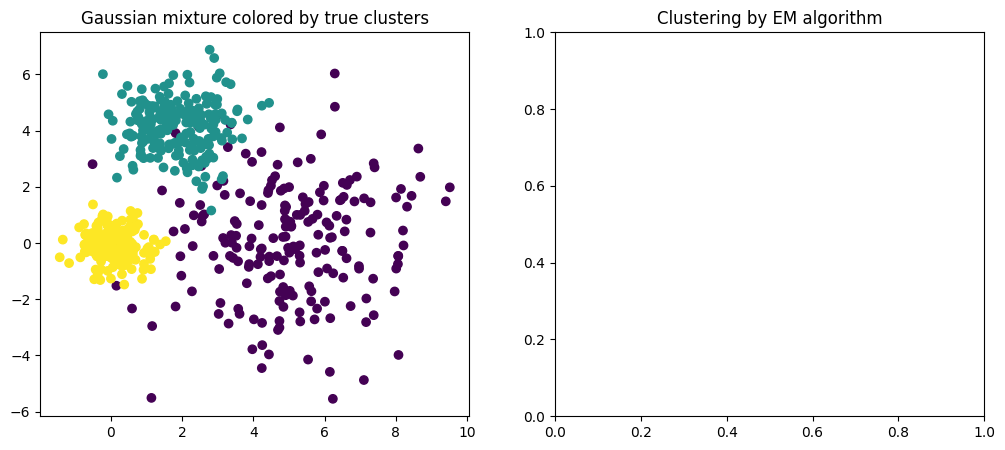

In [ ]:
# Generate some synthetic 2-dimensional data
# Roughly recreating the sample from the handout of Dr. Hagemann
X = np.vstack((np.random.multivariate_normal((5,0), [[4, 0], [0, 4]], 200),
               np.random.multivariate_normal((2,4), [[.9, 0], [0, .9]], 200),
               np.random.multivariate_normal((0,0), [[.25, 0], [0, .25]], 200)))
true_labels = np.zeros(600, dtype=int)
true_labels[200:400] = 1
true_labels[400:] = 2

plot_1 = plt.subplot(1, 2, 1)
plt.subplots_adjust(bottom=0.1, right=1.6, top=0.9)
plt.scatter(X[:, 0], X[:, 1], c=true_labels)
plt.title("Gaussian mixture colored by true clusters")

# Run EM clusterer on the data
# SoftKM = GMM(k=3)
# SoftKM(X).fit(X)
# labels, means = SoftKM(X).predict(X)

# plot_2 = plt.subplot(1, 2, 2)
# plt.scatter(X[:, 0], X[:, 1], c=)
# plt.title("Clustering by EM algorithm")
# plt.show()

## Task 2.2.2 - Regularizing the GMM (BONUS)

* Implement regularization techniques for the covariance matrices to towards the assumption of uncorrelated input features. Extend the existing `GMM` class above. **(RESULT)**

In [ ]:
# TODO

## Congratz, you made it! :)